In [1]:
from musicparser.data_loading import JTBDataset, TSDataset
import wandb
from musicparser.data_loading import JTBDataModule
from musicparser.models import ArcPredictionLightModel
from musicparser.postprocessing import eisner_fast
from pytorch_lightning import Trainer
import os
import torch
import numpy as np
from pathlib import Path
import json
from musicparser.data_loading import parse_jht_to_dep_tree

/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dataset = TSDataset(
            Path("data/gttm"),
            will_use_embeddings=True,
            data_augmentation="no",
            n_jobs=20,
        )

Loading data...


  7%|▋         | 20/300 [00:00<00:04, 69.14it/s]/share/home/francesco/musicparser/musicparser/data_loading.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_arc = torch.tensor(d_arc)
/share/home/francesco/musicparser/musicparser/data_loading.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_arc = torch.tensor(d_arc)
/share/home/francesco/musicparser/musicparser/data_loading.py:250: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/IndexingUtils.h:27.)
  pot_arcs = pot_arcs[~np.logical_or(starting_rest_mask, ending_rest_mask)]
/shar

Trying to solve first measure error in:  data/gttm/154/TS.xml
Trying to solve first measure error in:  data/gttm/169/TS.xml
!!!!! Error with 169_unknown.txt Can't assign ids in: data/gttm/169/TS.xml, error: index 3 is out of bounds for axis 0 with size 3
!!!!! Error with 154_unknown.txt Can't assign ids in: data/gttm/154/TS.xml, error: index 6 is out of bounds for axis 0 with size 6


/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/io/importmusicxml.py:871: UserWarning: ignoring direction type: bracket {'line-end': 'down', 'number': '1', 'type': 'stop'}
  warnings.warn("ignoring direction type: {} {}".format(dt.tag, dt.attrib))
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/directions.py:533: UserWarning: error parsing "contabile ed espressivo" (UnexpectedCharacters)
  warnings.warn('error parsing "{}" ({})'.format(string, type(e).__name__))
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/directions.py:533: UserWarning: error parsing "poco riten." (UnexpectedCharacters)
  warnings.warn('error parsing "{}" ({})'.format(string, type(e).__name__))
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/directions.py:533: UserWarning: error parsing "poco rit    -   -   -   -   -    -   -    -  " (UnexpectedCharacters)
 

Trying to solve first measure error in:  data/gttm/280/TS.xml
Trying to solve first measure error in:  data/gttm/291/TS.xml
!!!!! Error with 291_unknown.txt Can't assign ids in: data/gttm/291/TS.xml, error: Trying to build an arc from a rest
Trying to solve first measure error in:  data/gttm/288/TS.xml
!!!!! Error with 288_unknown.txt Can't assign ids in: data/gttm/288/TS.xml, error: Trying to build an arc from a rest
Trying to solve first measure error in:  data/gttm/283/TS.xml
Trying to solve first measure error in:  data/gttm/285/TS.xml
Trying to solve first measure error in:  data/gttm/276/TS.xml
Trying to solve first measure error in:  data/gttm/278/TS.xml


/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/io/importmusicxml.py:871: UserWarning: ignoring direction type: octave-shift {'default-y': '22', 'size': '8', 'type': 'down'}
  warnings.warn("ignoring direction type: {} {}".format(dt.tag, dt.attrib))
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/partitura/io/importmusicxml.py:871: UserWarning: ignoring direction type: octave-shift {'size': '8', 'type': 'stop'}
  warnings.warn("ignoring direction type: {} {}".format(dt.tag, dt.attrib))


Removed 4 scores due to errors


In [15]:
import pandas as pd

scores = dataset.score_files
folders = [Path(score).parent for score in scores]
titles = []
for fold in folders:
    # find the file that end with txt
    txt_file = [x for x in fold.iterdir() if x.suffix == ".txt"]
    assert len(txt_file) == 1
    # append the name of the file as title
    titles.append(txt_file[0].stem)

note_features = dataset.note_features
df = pd.DataFrame({
    "len": [len(c) for c in note_features],
    "titles": titles,
    })

df.to_csv("len.csv")

In [16]:
df

,len,titles
0,28,01_Waltz in E flat Grande Valse Brillante Op.18
1,33,02_Moments Musicaux
2,40,03_Bagatelle 'Fur Elise' WoO.59
3,33,04_The Preludes Op.28 No.15
4,34,05_Turkish March
...,...,...
291,16,95_12 Variationen uber ein franzosisches Lied ...
292,27,96_Lieder ohne Worte Heft 5 Op.62-6 Fruhlingslied
293,17,97_Les Patineurs Op.183
294,23,98_Sonate fur Klavier Nr.8 c moll Pathetique O...


In [4]:
dataset.chords_features[8].shape

(16, 5)

In [5]:
# run = wandb.init()
# artifact = run.use_artifact('fosfrancesco/loo_JTB/model-go1417zv:v0', type='model')
# artifact_dir = artifact.download()

artifact_dir = "artifacts/model-go1417zv:v0"

In [45]:
datamodule = JTBDataModule(batch_size=1, num_workers=1, data_augmentation="preprocess", only_tree=True, loo_index=8)
datamodule.setup()
model = ArcPredictionLightModel.load_from_checkpoint(checkpoint_path=os.path.join(os.path.normpath(artifact_dir), "model.ckpt"))

wandb_logger = True

trainer = Trainer(
    max_epochs=60, accelerator="auto", devices= [0], #strategy="ddp",
    num_sanity_val_steps=1,
    logger=wandb_logger,
    deterministic=True
    )

# trainer.tune(model, datamodule=datamodule)
# print("LR set to", model.lr)
out_dict= trainer.predict(model, dataloaders=datamodule.test_dataloader())[0]

Loading complete tree data...
Done loading data. 0 out of 150 pieces were discarded because of errors.
Augmenting data...
Augmenting data...
Train size :1788, Val size :1, Test size :1
No pretraining data


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [20]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(path = "fosfrancesco/sweeps_JTB")
# filters={"config.group": "LOO1"}

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
        if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

{'epoch': 60,
 'test_ctrees': {'_type': 'table-file',
  'ncols': 2,
  'nrows': 1,
  'sha256': '742bb1ea839f0cbf52ed9e8245bd0aee409171d7d56846f84a472d6e7c9e0f7a',
  'artifact_path': 'wandb-client-artifact://4t2m2q1w42c5ysyv54wvg6hgzio2qremiq7s3x0hxvl6kz4e8roq4k8r253fs7lkske93db6f8fxtciajt8bdco308spxr1609o6or38nvljnc5r77tb8c117zvc0xk1:latest/test_ctrees.table.json',
  '_latest_artifact_path': 'wandb-client-artifact://4t2m2q1w42c5ysyv54wvg6hgzio2qremiq7s3x0hxvl6kz4e8roq4k8r253fs7lkske93db6f8fxtciajt8bdco308spxr1609o6or38nvljnc5r77tb8c117zvc0xk1:latest/test_ctrees.table.json',
  'path': 'media/table/test_ctrees_4533_742bb1ea839f0cbf52ed.table.json',
  'size': 492},
 'test_head_seqs': {'ncols': 3,
  'nrows': 1,
  'sha256': '6a1fc272f7dbcc0fe8e7160f40c12d3dca28ad7dcdd539cbd595a1fc16619f30',
  'artifact_path': 'wandb-client-artifact://4v642fo375lygoqegmzd80oe7vbb6dntzxpad1m6nrwyj33ydkxw2dspvptp6wpjf4d78j3j2mnzs6rqoeiykj1m59qzgyetph63ymkgjp0wi62z9s3owwp35wmb6rmb:latest/test_head_seqs.table.jso

NameError: name 'pd' is not defined

In [33]:
import seaborn as sns
import pandas as pd

In [45]:
df = pd.read_csv("FormattedResults.csv")

In [46]:
df

,Accuracy,Model,Value
0,Arc,Harasim,0.750
1,Arc,Harasim,1.000
2,Arc,Harasim,1.000
3,Arc,Harasim,1.000
4,Arc,Harasim,0.917
...,...,...,...
745,Head,MuDeP,0.743
746,Head,MuDeP,0.943
747,Head,MuDeP,0.919
748,Head,MuDeP,0.784


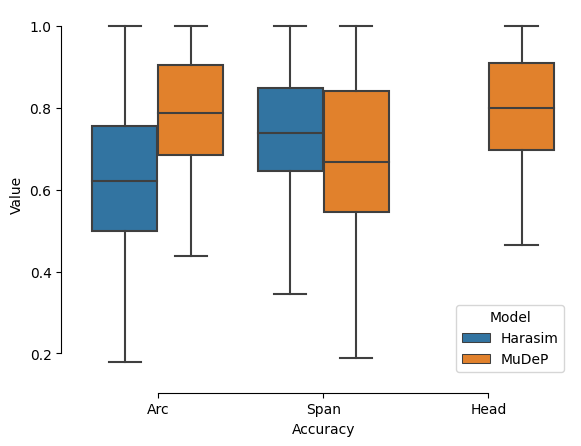

In [49]:

# Load the example tips dataset
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Accuracy", y="Value",
            hue="Model",
            data=df)
sns.despine(offset=10, trim=True)

In [38]:
tips = sns.load_dataset("tips")

In [39]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


# Graphic visualization of trees

1. Download the trees from wandb

import wandb
run = wandb.init()
artifact = run.use_artifact('fosfrancesco/sweeps_JTB/model-zgzanttn:v0', type='model')
artifact_dir = artifact.download()

run-akrl4j0y-head_seqs:v9

api = wandb.Api()
artifact = api.artifact('entity/project/artifact:alias')
artifact.download()

In [32]:
import wandb
run = wandb.init()
artifact = run.use_artifact('fosfrancesco/sweeps_JTB/run-kujfaczw-head_seqs:latest', type='run_table')
artifact_dir = artifact.download()
print(artifact_dir)

wandb:   1 of 1 files downloaded.  


./artifacts/run-kujfaczw-head_seqs:v41


In [17]:
artifact = api.run('fosfrancesco/sweeps_JTB/kujfaczw')

In [28]:
api = wandb.Api()
all_data = {}
sweep = api.sweep("fosfrancesco/sweeps_JTB/ekr597pd")
# load the json dataset (to get the exact chords)
with open(Path("data/jazz_tb/treebank.json")) as f:
    treebank_data = json.load(f)
treebank_data = [e for e in treebank_data if e.get("trees") is not None]
tree_dicts = [e["trees"][0]["complete_constituent_tree"] if e.get("trees") is not None else None for e in treebank_data ]
for run in sweep.runs:
    piece = run.name.split("-")[-1]
    # download test_head_seqs artifact
    artifact = api.artifact(f'fosfrancesco/sweeps_JTB/run-{run.id}-test_head_seqs:latest', type='run_table')
    folder_path = artifact.download()
    with open(Path(folder_path,"test_head_seqs.table.json")) as f:
        data = json.load(f)
    head_predicted = eval(data["data"][0][0])[1:] # first element is for the root, we discard it
    head_predicted_postp = eval(data["data"][0][1])[1:]
    head_truth = eval(data["data"][0][2])[1:]
    # download test_ctree artifact
    artifact = api.artifact(f'fosfrancesco/sweeps_JTB/run-{run.id}-test_ctrees:latest', type='run_table')
    folder_path = artifact.download()
    with open(Path(folder_path,"test_ctrees.table.json")) as f:
        data = json.load(f)
    ctree_predicted = data["data"][0][0]
    ctree_truth = data["data"][0][1]
    # load the chord sequence
    arcs, chord_sequence = parse_jht_to_dep_tree(tree_dicts[int(piece)-1])
    assert len(chord_sequence) == len(head_predicted_postp) , f"Chord sequence and head predicted have different length for piece {piece}, {len(chord_sequence)}!={len(head_predicted_postp)}"
    # save everything
    all_data[piece] = {"head_predicted" : head_predicted,
                       "head_predicted_postp" : head_predicted_postp,
                       "head_truth" : head_truth,
                       "ctree_predicted" : ctree_predicted,
                       "ctree_truth" : ctree_truth,
                       "chords" : chord_sequence,
                       "arcs:": arcs}

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

In [29]:
with open(Path('results/predicted_JHT.json'), 'w') as outfile:
    json.dump(all_data, outfile)

In [14]:
from musicparser.data_loading import parse_jht_to_dep_tree

# # add chord sequence to all data
# with open(Path("data/jazz_tb/treebank.json")) as f:
#     treebank_data = json.load(f)
# treebank_data = [e for e in treebank_data if e.get("trees") is not None]
# tree_dicts = [e["trees"][0]["complete_constituent_tree"] if e.get("trees") is not None else None for e in treebank_data ]
# d_arc, ch = parse_jht_to_dep_tree(tree_dicts[149])
# len(ch)



38

0, 2, 17, 4, 5, 6, 7, 8, 9, 12, 12, 12, 13, 14, 15, 17, 17, 38, 19, 38, 21, 23, 23, 25, 25, 26, 28, 28, 30, 30, 31, 32, 38, 34, 35, 36, 38, 38, 0]
['Am6', 'Am6', 'Abo7', 'Abo7', 'Gm7', 'C7', 'F^7', 'F^7', 'F^7', 'Fm7', 'Bb7', 'Em7', 'A7', 'D7', 'D7', 'Dm7', 'G7', 'Am6', 'Am6', 'Abo7', 'Abo7', 'Gm7', 'C7', 'F^7', 'F^7', 'F^7', 'Fm7', 'Bb7', 'Em7', 'Am7', 'Dm7', 'G7', 'Em7', 'A7', 'Dm7', 'G7', 'C6', 'C6']
146 38


'[[1, 2], [[[[[[[[[[[3, 4], 5], 6], 7], 8], 9], [10, [11, 12]]], 13], 14], 15], [16, 17]]], [[18, 19], [[[[[[[[[20, 21], [22, 23]], [24, 25]], 26], [27, 28]], [29, 30]], 31], 32], [[[[33, 34], 35], 36], [37, 38]]]]]'

In [67]:
from spacy import displacy

piece_data = all_data["2"]

spacy_words = [{"text": chord, "tag": ""} for chord in piece_data["chords"]]
spacy_arcs = []
for start_ix, end_ix in enumerate(piece_data["head_truth"]):
    if end_ix == 0:
        continue # skip root
    if start_ix < end_ix-1:
        spacy_arcs.append({"start": start_ix, "end": end_ix-1, "label": "", "dir": "right"})
    else:
        spacy_arcs.append({"start": end_ix-1, "end": start_ix, "label": "", "dir": "left"})


spacy_dict = {"words": spacy_words, "arcs": spacy_arcs}
displacy.render(spacy_dict, style='dep', jupyter=True, manual=True, options={"compact": False, "distance": 80, "arrow_stroke":1, "arrow_width":6, "word_spacing":20})


In [72]:
for piece in all_data:
    piece_data = all_data[piece]
    title = titles[int(piece)-1]
    spacy_words = [{"text": chord, "tag": ""} for chord in piece_data["chords"]]
    spacy_arcs = []
    for start_ix, end_ix in enumerate(piece_data["head_truth"]):
        if end_ix == 0:
            continue # skip root
        if start_ix < end_ix-1:
            spacy_arcs.append({"start": start_ix, "end": end_ix-1, "label": "", "dir": "right"})
        else:
            spacy_arcs.append({"start": end_ix-1, "end": start_ix, "label": "", "dir": "left"})


    spacy_dict = {"words": spacy_words, "arcs": spacy_arcs}
    render_options = {"compact": False, "distance": 80, "arrow_stroke":1, "arrow_width":6, "word_spacing":20}
    rendered_tree = displacy.render(spacy_dict, style='dep', jupyter=False, manual=True, options=render_options)
    output_path = Path(f"./results/rendered_JHT/dependency_trees/ground_truth/{title}.svg")
    with output_path.open("w", encoding="utf-8") as f:
        f.write(rendered_tree)

In [74]:
# generate the markdown automatically
# for each piece use the template
# ## Title
# ### Ground Truth
# <img src="../results/rendered_JHT/dependency_trees/ground_truth/title.svg"> 

# ### Predicted with no postprocessing
# <img src="../results/rendered_JHT/dependency_trees/predicted_no_postprocessing/title.svg"> 

# ### Predicted with postprocessing
# <img src="../results/rendered_JHT/dependency_trees/predicted_postprocessing/title.svg"> 

markdown = ""
# add the css style 
# <style>
#     img {
#         max-width: 2000%;
#         overflow: auto;
#     }
# </style>
markdown += "<style> img { max-width: 2000%; overflow-x: scroll; } </style>\n"
for piece in all_data:
      title = titles[int(piece)-1]
      markdown += f"## {title}\n"
      markdown += f"### Ground Truth\n"
      markdown += f"<img src=\"../results/rendered_JHT/dependency_trees/ground_truth/{title}.svg\"> \n \n"
      markdown += f"### Predicted with no postprocessing\n"
      markdown += f"<img src=\"../results/rendered_JHT/dependency_trees/predicted_no_postprocessing/{title}.svg\"> \n \n"
      markdown += f"### Predicted with postprocessing\n"
      markdown += f"<img src=\"../results/rendered_JHT/dependency_trees/predicted_postprocessing/{title}.svg\"> \n \n"

# save the markdown in the result folder
with open(Path("results/rendered_JHT.md"), "w") as f:
      f.write(markdown)
    

In [45]:
predicted

'[0, 2, 17, 4, 5, 6, 7, 8, 9, 12, 12, 12, 13, 14, 15, 17, 17, 38, 19, 38, 21, 23, 23, 25, 25, 26, 28, 28, 30, 30, 31, 32, 38, 34, 35, 36, 38, 38, 0]'